## MNIST CNN

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
import torchvision
import torchvision.transforms as transforms

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    )

In [4]:
testset.classes, trainset.classes == testset.classes

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 True)

In [5]:
testset, trainset

(Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test,
 Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train)

In [6]:
path_template = "./data/fashionmnist_c_png/{dataset}/{label}/{idx}.png"

for ds, ds_name in [
    (trainset, "train"),
    (testset, "test")
]:
    for idx, (img, label) in enumerate(ds):
        path = Path(path_template.format(dataset=ds_name, label=testset.classes[label], idx=idx))
        path.parent.mkdir(exist_ok=True, parents=True)
        img.save(path)



### Data

In [7]:
t = PIL.Image.open("/home/sergey/.fastai/data/mnist_png/testing/2/1002.png")
t = PIL.Image.open("./data/fashionmnist_c_png/test/Coat/1026.png")

In [8]:
t.getbands()

('L',)

In [9]:
path = Path("./data/fashionmnist_c_png/")

In [10]:
il = ImageList.from_folder(path, convert_mode='L')

In [11]:
il.items[0]

PosixPath('data/fashionmnist_c_png/train/Shirt/50398.png')

In [12]:
defaults.cmap='binary'

In [13]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: data/fashionmnist_c_png

In [ ]:
il[0].show()

In [15]:
sd = il.split_by_folder(train='train', valid='test')

In [16]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: data/fashionmnist_c_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: data/fashionmnist_c_png;

Test: None

In [17]:
(path/'train').ls()

[PosixPath('data/fashionmnist_c_png/train/Shirt'),
 PosixPath('data/fashionmnist_c_png/train/Sandal'),
 PosixPath('data/fashionmnist_c_png/train/Dress'),
 PosixPath('data/fashionmnist_c_png/train/Coat'),
 PosixPath('data/fashionmnist_c_png/train/Ankle boot'),
 PosixPath('data/fashionmnist_c_png/train/Trouser'),
 PosixPath('data/fashionmnist_c_png/train/Pullover'),
 PosixPath('data/fashionmnist_c_png/train/T-shirt'),
 PosixPath('data/fashionmnist_c_png/train/Sneaker'),
 PosixPath('data/fashionmnist_c_png/train/Bag')]

In [19]:
ll = sd.label_from_folder()

In [20]:
ll

LabelLists;

Train: LabelList (54000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
Shirt,Shirt,Shirt,Shirt,Shirt
Path: data/fashionmnist_c_png;

Valid: LabelList (9000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
Shirt,Shirt,Shirt,Shirt,Shirt
Path: data/fashionmnist_c_png;

Test: None

In [21]:
x,y = ll.train[0]

In [ ]:
x.show()
print(y,x.shape)

In [83]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [84]:
ll = ll.transform(tfms)

In [25]:
bs = 128

In [26]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [27]:
x,y = data.train_ds[0]
x1,y1 = data.train_ds[0]

In [28]:
torch.max(x1.data-x.data)

tensor(0.9647)

In [29]:
x

In [30]:
Image(x.data-x1.data)

In [31]:
x.size

torch.Size([28, 28])

In [ ]:
x.show()
x1.show()
print(y)

In [ ]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [56]:
xb,yb = data.one_batch(ds_type='valid')
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [ ]:
data.show_batch(rows=5, figsize=(5,5))

### Basic CNN with batchnorm

In [36]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [37]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [38]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [39]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [42]:
xb = xb.cuda()

In [43]:
model(xb).shape

torch.Size([128, 10])

In [44]:
learn.lr_find(end_lr=100)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


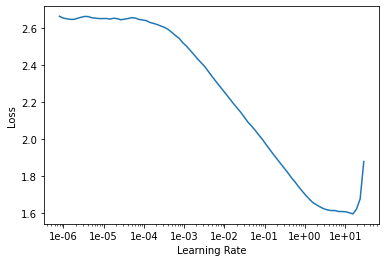

In [45]:
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.564975,0.543564,0.785667,00:03
1,0.452353,0.404379,0.846222,00:03
2,0.353558,0.325759,0.881000,00:03


### Refactor

In [47]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [48]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [49]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [50]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.530116,0.487697,0.813556,00:03
1,0.480595,0.521950,0.804889,00:03
2,0.440480,0.427721,0.843111,00:03
3,0.427494,0.386877,0.856111,00:03
4,0.402840,0.354544,0.867222,00:03
5,0.370519,0.323333,0.885333,00:03
6,0.345101,0.300173,0.886000,00:03
7,0.317025,0.338033,0.872444,00:03
8,0.292034,0.257452,0.903444,00:03
9,0.269478,0.251515,0.908111,00:03


### Resnet-ish

In [69]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [70]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [71]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [72]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [73]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [74]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


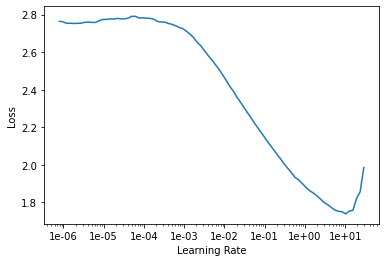

In [75]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [77]:
learn.fit_one_cycle(12, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.220697,0.242877,0.912111,00:05
1,0.281594,0.327464,0.880111,00:05
2,0.332012,0.376261,0.865000,00:05
3,0.335107,0.343163,0.872222,00:05
4,0.331796,0.374355,0.864222,00:05
5,0.308323,0.437040,0.840889,00:05
6,0.291689,0.266811,0.902778,00:05
7,0.266840,0.258459,0.903556,00:05
8,0.246418,0.235561,0.914222,00:05
9,0.216895,0.253996,0.903667,00:05


In [78]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________

In [79]:
learn.fit_one_cycle(5, max_lr=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.194056,0.198887,0.928000,00:05
1,0.200892,0.206060,0.924667,00:05
2,0.200909,0.190393,0.932333,00:05
3,0.182028,0.190148,0.930444,00:05
4,0.189892,0.183790,0.934444,00:05


In [80]:
learn.fit_one_cycle(10, max_lr=0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.185247,0.182775,0.934222,00:05
1,0.182003,0.183360,0.933333,00:05
2,0.177185,0.182586,0.935111,00:05
3,0.175482,0.181457,0.933778,00:05
4,0.186998,0.179595,0.935556,00:05
5,0.185074,0.181984,0.935222,00:05
6,0.172677,0.180776,0.935000,00:05
7,0.173282,0.180003,0.935667,00:05
8,0.171820,0.180453,0.935222,00:05
9,0.172177,0.180474,0.936222,00:05


## fin